## 概览
在这篇讲座中，我们继续上一篇讲稿的学习，但是我们offer的工资分布将会变成一个连续的分布。

尽管在本模型的第一篇讲稿中已经简单考虑了一个连续的工资分布，但在那个例子里面这点改变根本微不足道。

这是因为我们能够将其简化为求解单个标量值（延续值）的问题。

而在本篇讲稿中，由于存在被解雇的可能性，这种改变就比较大了，因为连续的工资分布会导致不可数的无限的状态空间。

无限的状态空间将会给我们带来额外的挑战，尤其是当我们在应用值函数迭代时（Value Function Iteration，VFI）时。

这些挑战将会使我们通过在VFI的过程中增加一个插值的步骤解决。

这种VFI和插值的结合被称为**拟合值函数迭代（fitted value function iteration，fitted VFI）**

Fitted VFI在实际使用中非常常见，因此我们会画一些时间来了解细节。

同样，我们从一些import开始：

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from interpolation import interp
from numpy.random import randn
from numba import njit, prange, float64, int32
from numba.experimental import jitclass

## 算法
该模型与我们之前研究的含解雇的McCall模型相同，只是工资的分布是连续的。

我们将直接从简化后的两个贝尔曼方程开始：
$$
d = \int \max \left\{ v(w'), \,  u(c) + \beta d \right\} q(w') d w' 
$$

和
$$
v(w) = u(w) + \beta
    \left[
        (1-\alpha)v(w) + \alpha d
    \right] 
$$

这里的未知数是函数$v$和标量$d$。

这里与我们之前所学的贝尔曼方程不同的地方在于：
1. 第一个式子中以往是一个有限集合的求和，现在则是无限集合上的积分。
2. $v$函数现在的定义域是所有$w \in \mathbb R_+$

$q$函数表示工资分布的概率密度。

### 值函数迭代
理论上，我们接下来的步骤应该是：
1. 首先猜测$v,d$
2. 将$v,d$代入等式右边，计算出新的$v',d'$
3. 除非终止条件得到满足，否则令$(v,d) = (v',d')$并回到第2步。

然而在实现这个过程之前，我们必须面对一个问题，即值函数的迭代并不能精确计算也或者储存在电脑中。

即使$v$是一个已知的函数，唯一储存$v'$的方法就是对每个$w \in \mathbb R_+$都记录其$v'(w)$的值。

显然，这是不可能的。

### 拟合值函数迭代
我们接下来要做的事情就是使用拟合值函数迭代。

过程如下：
从初始的猜测$v$开始

我们只在有限多个“网格”点$w_1<w_2<...<$记录$v'$的值,然后再需要时根据这些信息"重建"我们的$v'$。

更细节的算法如下：
1. 从一个数组表示网格点$\{w_i\}$上的初始猜测值的数组$\mathbf v$开始。
2. 通过基于$\mathbf v$和$\{w_i\}$在状态空间上进行插值和近似去构建函数$v$。
3. 获取并且记录每个网点$w_i$的更新过后的函数$v'(w_i)$
4. 除非终止条件得到满足，将这个新的数组返回到步骤1。

那我们如何实现步骤2呢？

这是一个关于函数近似的问题，并且有很多方法去实现他。

重要的是，函数近似的方案不仅必须对每一个$v$都产生良好的近似，还必须与上述的迭代算法很好的结合。

一个比较好的选择是连续分段线性插值。

这个方法：
1. 很好地结合了值函数迭代，并且
2. 保留了一些关于函数有用的特性如单调性和凹凸性。

这样的线性插值将使用一个叫做interpolation.py的支持JIT的Python插值库来实现。

下一张图展示了网点$0,0.2,0.4,0.6,0.8,1$上一个任意函数的分段线性插值：

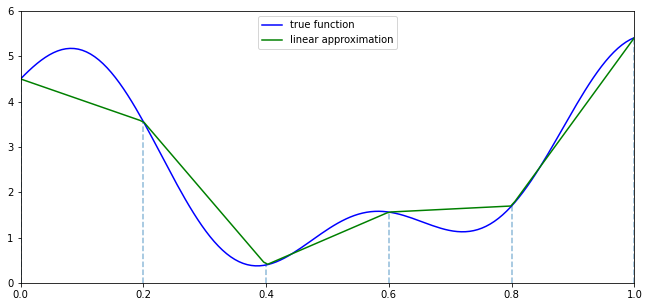

In [3]:
def f(x):
    y1 = 2 * np.cos(6 * x) + np.sin(14 * x)
    return y1 + 2.5

c_grid = np.linspace(0, 1, 6)
f_grid = np.linspace(0, 1, 150)

def Af(x):
    return interp(c_grid, f(c_grid), x)

fig, ax = plt.subplots()

ax.plot(f_grid, f(f_grid), 'b-', label='true function')
ax.plot(f_grid, Af(f_grid), 'g-', label='linear approximation')
ax.vlines(c_grid, c_grid * 0, f(c_grid), linestyle='dashed', alpha=0.5)

ax.legend(loc="upper center")

ax.set(xlim=(0, 1), ylim=(0, 6))
plt.show()

## 实现
第一步是为一个具有解雇和连续的工资分布的McCall模型建立一个JIT类。

我们将假设效用函数满足对数形式：$u(c) = \ln c$

我们假设工资的分布满足对数正态分布：$w = \exp(\mu+\sigma z)$，其中$z$满足标准正态分布，$\mu,\sigma$是参数。

In [4]:
@njit
def lognormal_draws(n=1000, μ=2.5, σ=0.5, seed=1234):
    np.random.seed(seed)
    z = np.random.randn(n)
    w_draws = np.exp(μ + σ * z)
    return w_draws

In [5]:
mccall_data_continuous = [
    ('c', float64),          # unemployment compensation
    ('α', float64),          # job separation rate
    ('β', float64),          # discount factor
    ('σ', float64),          # scale parameter in lognormal distribution
    ('μ', float64),          # location parameter in lognormal distribution
    ('w_grid', float64[:]),  # grid of points for fitted VFI
    ('w_draws', float64[:])  # draws of wages for Monte Carlo
]

@jitclass(mccall_data_continuous)
class McCallModelContinuous:

    def __init__(self,
                 c=1,
                 α=0.1,
                 β=0.96,
                 grid_min=1e-10,
                 grid_max=5,
                 grid_size=100,
                 w_draws=lognormal_draws()):

        self.c, self.α, self.β = c, α, β

        self.w_grid = np.linspace(grid_min, grid_max, grid_size)
        self.w_draws = w_draws

    def update(self, v, d):

        # Simplify names
        c, α, β, σ, μ = self.c, self.α, self.β, self.σ, self.μ
        w = self.w_grid
        u = lambda x: np.log(x)

        # Interpolate array represented value function
        vf = lambda x: interp(w, v, x)

        # Update d using Monte Carlo to evaluate integral
        d_new = np.mean(np.maximum(vf(self.w_draws), u(c) + β * d))

        # Update v
        v_new = u(w) + β * ((1 - α) * v + α * d)

        return v_new, d_new

In [6]:
@njit
def solve_model(mcm, tol=1e-5, max_iter=2000):
    """
    Iterates to convergence on the Bellman equations

    * mcm is an instance of McCallModel
    """

    v = np.ones_like(mcm.w_grid)    # Initial guess of v
    d = 1                           # Initial guess of d
    i = 0
    error = tol + 1

    while error > tol and i < max_iter:
        v_new, d_new = mcm.update(v, d)
        error_1 = np.max(np.abs(v_new - v))
        error_2 = np.abs(d_new - d)
        error = max(error_1, error_2)
        v = v_new
        d = d_new
        i += 1

    return v, d

下面是函数`compute_reservation_wage`，它接受一个`McCallModelContinuous`类的实例并且返回相应的保留价格。

如果对于所有的$w$，$v(w)<h$，这个函数就会返回np.inf(代表无穷大)。

In [7]:
@njit
def compute_reservation_wage(mcm):
    """
    Computes the reservation wage of an instance of the McCall model
    by finding the smallest w such that v(w) >= h.

    If no such w exists, then w_bar is set to np.inf.
    """
    u = lambda x: np.log(x)

    v, d = solve_model(mcm)
    h = u(mcm.c) + mcm.β * d

    w_bar = np.inf
    for i, wage in enumerate(mcm.w_grid):
        if v[i] > h:
            w_bar = wage
            break

    return w_bar

下面的练习要求您探索保留价格如何随着参数的变化而变化。

## 练习
### 练习1
使用上面的代码探讨当工资分布的参数$\mu$发生改变时，保留价格将会如何变化。
`mu_vals = np.linspace(0.0, 2.0, 15)`

其对保留价格的影响如你所料吗？
### 练习2
现在让给我们考虑代理人如何应对波动的增加。

为了试图理解这一点，我们假设工资分布满足$(m-s,m+s)$之间的均匀分布，$s$是变量。

即我们保持均值不变，但是改变范围。

（这是*均值保留展开（mean-preserving spread）* 的一种形式）

其对保留价格的影响如你所料吗？

## 解答
### 练习1

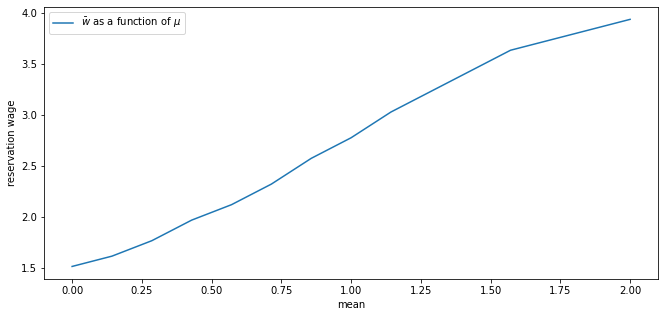

In [8]:
mcm = McCallModelContinuous()
mu_vals = np.linspace(0.0, 2.0, 15)
w_bar_vals = np.empty_like(mu_vals)

fig, ax = plt.subplots()

for i, m in enumerate(mu_vals):
    mcm.w_draws = lognormal_draws(μ=m)
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='mean', ylabel='reservation wage')
ax.plot(mu_vals, w_bar_vals, label=r'$\bar w$ as a function of $\mu$')
ax.legend()

plt.show()

果然，当工资的分布右移时，代理人更倾向于等待。

### 练习2

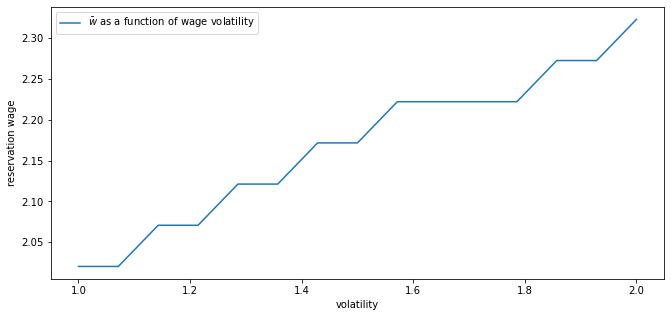

In [9]:
mcm = McCallModelContinuous()
s_vals = np.linspace(1.0, 2.0, 15)
m = 2.0
w_bar_vals = np.empty_like(s_vals)

fig, ax = plt.subplots()

for i, s in enumerate(s_vals):
    a, b = m - s, m + s
    mcm.w_draws = np.random.uniform(low=a, high=b, size=10_000)
    w_bar = compute_reservation_wage(mcm)
    w_bar_vals[i] = w_bar

ax.set(xlabel='volatility', ylabel='reservation wage')
ax.plot(s_vals, w_bar_vals, label=r'$\bar w$ as a function of wage volatility')
ax.legend()

plt.show()

保留工资随着波动性的增加而增加。

有人可能认为更高的波动性会使代理人更倾向于接受工资报价，因为这代表了确定性，而继续等待则面临着风险。

但事实上，求职就代表工人具有选择权：他只会面临上行的风险（因为在自由的市场中，没有人能够强迫他接受一个较低的工资价格）

更多的波动性意味着更高的上涨潜力，这也会鼓励代理人继续等待。